In [1]:
using PyPlot
using PyCall
using Peaks
np=pyimport("numpy")
eV = 27.2114; #Hartree to eV conversion
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 15
rcParams["legend.fontsize"] = "small"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.titlesize"] = "xx-large"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams["font.sans-serif"] = "Arial"
rcParams["font.family"] = "sans-serif"
rcParams["figure.figsize"] = (6, 6);

In [2]:
dir_nohybrid = string(pwd(), "/nohybrid");

In [3]:
# We consider the following range of wavelengths to be "green":
println("Green range: ", round(1240/2.3, digits=3) ,"nm to ", round(1240/2.6, digits=3), "nm")
println("Red range: ", round(1240/1.8, digits=3) ,"nm to ", round(1240/2, digits=3), "nm")

Green range: 539.13nm to 476.923nm
Red range: 688.889nm to 620.0nm


In [4]:
#Loop over all simulations and store the band indices and oscillator strengths corresponding to the 
#relevant green and red transitions. 
AllValidPairsGreen = Vector{Tuple{String, Vector{Tuple{Integer, Integer, Integer, Float64, Float64}}}}()
# Vector of tuples of the form: (ID, (spin, lowerband, upperband, energydiff, oscillator strength))
AllValidPairsRed = Vector{Tuple{String, Vector{Tuple{Integer, Integer, Integer, Float64, Float64}}}}()
# Vector of tuples of the form: (ID, (spin, lowerband, upperband, energydiff, oscillator strength))
#in the end since we have no phase interfering terms. 
transitioneigenvals = Float64[]
for (i, j) in Tuple.(CartesianIndices(rand(4, 5)))
    id="$(i)$(j)"
    μ=0 
    (isfile("$dir_nohybrid/STH2$(id).eigStats") && isfile("$dir_nohybrid/STH2$(id).momenta") && isfile("$dir_nohybrid/STH2$(id).eigenvals")) || continue
    for l in readlines("$dir_nohybrid/STH2$(id).eigStats")
        if VERSION.minor >= 5  
            contains(l, "mu" ) || continue ;
        elseif VERSION.minor < 5
            occursin("mu", l) || continue ;
        end
        μ = parse(Float64, l[6:end]);
    end
    eigenvalsup = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[1:48]*eV
    eigenvalsdn = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[49:96]*eV
    momenta = np.reshape(abs.(np.fromfile("$dir_nohybrid/STH2$(id).momenta", dtype=np.complex )), (2, 3, 48, 48));
    (permutedims(momenta, (1, 2, 4, 3)) ≈ conj(momenta)) || error("Momenta Do Not Satisfy Hermiticity Condition")

    ValidPairsGreen = Vector{Tuple{Integer, Integer, Integer, Float64, Float64}}() 
    ValidPairsRed = Vector{Tuple{Integer, Integer, Integer, Float64, Float64}}() 

    for spin in [1, 2]
        transitioneigenvals = (spin == 1) ? eigenvalsup : eigenvalsdn
        for (i, e) in enumerate(transitioneigenvals)
            for (j, eprime) in enumerate(transitioneigenvals)
                (i > 10 && j > 10 ) || continue # Only look at particular range of bands
                (i < 30 && j < 30) || continue # Only look at particular range of bands
                if (2.3 < abs(e-eprime) < 2.6) # Range for green transitions
                    #Note that we must convert back from eV to hartree, so the denominator is divided by 27.2
                    !((j, i) in [v[2:3] for v in ValidPairsGreen]) && push!(ValidPairsGreen, (spin, i, j, abs(e-eprime), eV*2/3*sum((abs.(momenta[spin, :, i, j])).^2)/abs(e-eprime) ))
                elseif (1.8 < abs(e-eprime) < 2) # Range for red transitions
                    !((j, i) in [v[2:3] for v in ValidPairsRed]) && push!(ValidPairsRed, (spin, i, j, abs(e-eprime), eV*2/3*sum((abs.(momenta[spin, :, i, j])).^2)/abs(e-eprime)))
                end
            end
        end
    end
    push!(AllValidPairsGreen, (id, ValidPairsGreen))
    push!(AllValidPairsRed, (id, ValidPairsRed))
end


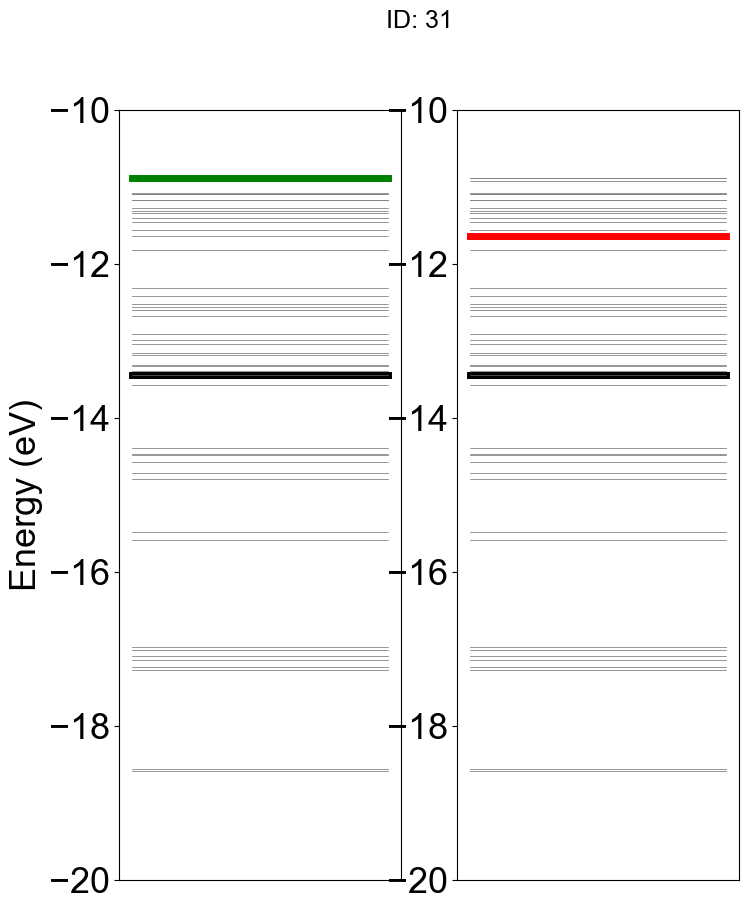

In [20]:
#figure(figsize=(20, 10))
#id, kpoint, band1, band2
Highest_Oscillators_Green = Vector{Tuple{String, Tuple{Integer, Integer, Integer, Float64, Float64}}}()
Highest_Oscillators_Red = Vector{Tuple{String, Tuple{Integer, Integer, Integer, Float64, Float64}}}()

for (ValidPairsGreen, ValidPairsRed) in zip(AllValidPairsGreen, AllValidPairsRed)
    figure(figsize=(8, 10))
    id = ValidPairsGreen[1]
    id!="31" && continue
    suptitle("ID: $id")
    eigenvalsup = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[1:48]*eV
    eigenvalsdn = np.fromfile("$dir_nohybrid/STH2$(id).eigenvals")[49:96]*eV
    momenta = np.reshape(abs.(np.fromfile("$dir_nohybrid/STH2$(id).momenta", dtype=np.complex )), (2, 3, 48, 48));
    maxgreen = argmax([v[5] for v in ValidPairsGreen[2]])
    maxred = argmax([v[5] for v in ValidPairsRed[2]])

    push!(Highest_Oscillators_Green, (id, ValidPairsGreen[2][maxgreen]))
    push!(Highest_Oscillators_Red, (id, ValidPairsRed[2][maxred]))

    subplot(1, 2, 1)
    for i in 1:48
        ((i == ValidPairsGreen[2][maxgreen][2]) && (ValidPairsGreen[2][maxgreen][1] == 1))  ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="gray", linewidth=.4);
        ((i == ValidPairsGreen[2][maxgreen][3]) && (ValidPairsGreen[2][maxgreen][1] == 1)) ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="green", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="gray", linewidth=.4);
        ((i == ValidPairsGreen[2][maxgreen][2]) && (ValidPairsGreen[2][maxgreen][1] == 2))  ? plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="gray", linewidth=.4);
        ((i == ValidPairsGreen[2][maxgreen][3]) && (ValidPairsGreen[2][maxgreen][1] == 2)) ? plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="green", linewidth=5) : plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="gray", linewidth=.4);
    end
    ylim(-20, -10)
    xticks([])
    ylabel("Energy (eV)")
    subplot(1, 2, 2)
    for i in 1:48
        ((i == ValidPairsRed[2][maxred][2]) && (ValidPairsRed[2][maxred][1] == 1))  ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="gray", linewidth=.4);
        ((i == ValidPairsRed[2][maxred][3]) && (ValidPairsRed[2][maxred][1] == 1)) ? plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="red", linewidth=5) : plot(reshape(np.repeat(eigenvalsup[i], 10), (10, 1)), color="gray", linewidth=.4);
        ((i == ValidPairsRed[2][maxred][2]) && (ValidPairsRed[2][maxred][1] == 2))  ? plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="black", linewidth=5) : plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="gray", linewidth=.4);
        ((i == ValidPairsRed[2][maxred][3]) && (ValidPairsRed[2][maxred][1] == 2)) ? plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="red", linewidth=5) : plot(reshape(np.repeat(eigenvalsdn[i], 10), (10, 1)), color="gray", linewidth=.4);
    end
    ylim(-20, -10)
    xticks([])
    savefig("energylevels.svg")
end

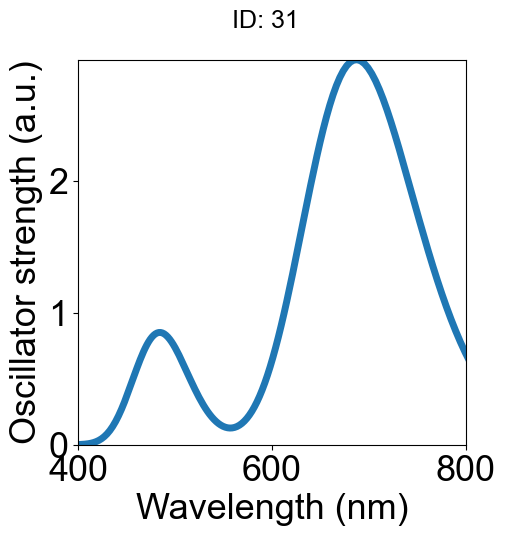

Peaks for id: 31: [687.8949315575287, 484.97130933750657]


In [16]:
energies = collect(range(1, 30, length=3000))
lambdas = 1240 ./ collect(range(1, 30, length=3000))
broadening=0.15

for (ValidPairsGreen, ValidPairsRed) in zip(Highest_Oscillators_Green, Highest_Oscillators_Red)
    
    figure(figsize=(5, 5))
    id = ValidPairsGreen[1]
    id != "31" && continue
    suptitle("ID: $id")
    FSTH2=zeros(100*30)

    ediff_green = ValidPairsGreen[2][4]
    strength_green = ValidPairsGreen[2][5]
    ediff_red = ValidPairsRed[2][4]
    strength_red  = ValidPairsRed[2][5]
    FSTH2 = strength_green*exp.(-0.5*(energies.-ediff_green).^2/(broadening)^2)
    FSTH2 += strength_red*exp.(-0.5*(energies.-ediff_red).^2/(broadening)^2)
    FSTH2 *= eV
    plot(lambdas, FSTH2, linewidth=5)
    ylabel("Oscillator strength (a.u.)")
    xlabel("Wavelength (nm)")
    xlim(400,800)
    ylim(0, maximum(FSTH2[argmin(abs.(lambdas .-800)):argmin(abs.(lambdas .- 400))]))
    println("Peaks for id: $id: ", lambdas[argmaxima(FSTH2)])
end
savefig("spectrum.svg")